# Disparity vector computation - Cylinder wake


## Description

Based on paper and source code:
 - Sciacchitano, A., Wieneke, B., & Scarano, F. (2013). PIV uncertainty quantification by image matching. *Measurement Science and Technology*, 24 (4). https://doi.org/10.1088/0957-0233/24/4/045302. 
 - http://piv.de/uncertainty/?page_id=221
 
**Step 1: Particle peak detection**

As described by (Sciacchitano et al., 2013, Eq. 1), the image intensity product $\Pi$ from image matching intensities is defined as:
$$
\Pi = \hat{I}_1\hat{I}_2
$$
The peaks image $\varphi$ is defined as:
$$
\varphi(i,j) = \begin{cases}
1\quad\text{if }\Pi(i,j)\text{ is a relative maximum} \\
0\quad\text{otherwise}
\end{cases}
$$

**Step 2: Disparity vector computation**

The sub-pixel peak position estimator adopted here is the standard 3-point Gaussian fit. The particle positions of times $t_1$ and $t_2$ are 
defined as $\boldsymbol{X}^1 = \{x^1_1,x^1_2,...,x^1_N\}$ and $\boldsymbol{X}^2 = \{x^2_1,x^2_2,...,x^2_N\}$. Discrete disparity vectors are defined as:
$$
\boldsymbol{D} = \boldsymbol{X}^2 - \boldsymbol{X}^1
$$


## Setup

**Packages**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import pivuq

**Load images**

In [3]:
parent_path = "./data/cylinder_wake/"
image_pair = np.array(
    [
        plt.imread(os.path.join(parent_path + ipath)).astype("float")
        for ipath in ["frameA.tif", "frameB.tif"]
    ]
)

**Load reference velocity**

In [4]:
data = np.load(os.path.join(parent_path + "vectors_OF.npz"))

X_ref = data["X"]  # already zero-indexed
Y_ref = data["Y"]
U_ref = data["U"]  # u, v

## Warp image pair

In [5]:
%%time
warped_image_pair = pivuq.warp(
    image_pair,
    U_ref,
    velocity_upsample_kind="linear",
    direction="center",
    nsteps=1,
    order=1,
)

CPU times: user 58.1 ms, sys: 10.2 ms, total: 68.3 ms
Wall time: 68.1 ms


**Plot warped images**

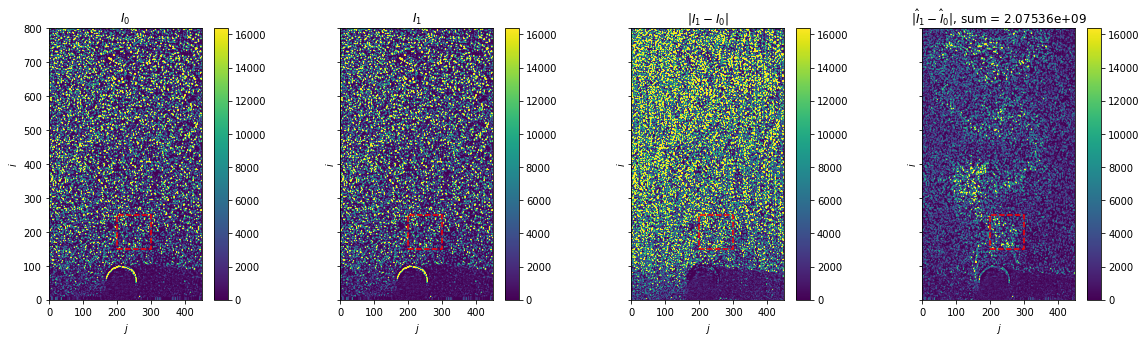

In [6]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 5))

for i, ax in enumerate(axes[:2]):
    im = ax.imshow(warped_image_pair[0], vmax=2**14)
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$I_{i}$")

ax = axes[-2]
im = ax.imshow(np.abs(image_pair[1] - image_pair[0]), vmax=2**14)
fig.colorbar(im, ax=ax)
ax.set(title="$|I_1 - I_0|$")


ax = axes[-1]
im = ax.imshow(np.abs(warped_image_pair[1] - warped_image_pair[0]), vmax=2**14)
fig.colorbar(im, ax=ax)
ax.set(
    title=f"$|\hat{{I}}_1 - \hat{{I}}_0|$, sum = {np.abs(warped_image_pair[1] - warped_image_pair[0]).sum():g}"
)

box = [200, 300, 150, 250]

for ax in axes:
    ax.set(xlim=(0, 450), ylim=(0, 800), xlabel="$j$", ylabel="$i$")
    ax.plot(
        [box[0], box[1], box[1], box[0], box[0]],
        [box[2], box[2], box[3], box[3], box[2]],
        "--",
        c="r",
    )

## Disparity vector computation

In [7]:
%%time
D, c = pivuq.lib.disparity_vector_computation(
    warped_image_pair, radius=1, sliding_window_size=16
)

peak_coords = np.stack(np.where(c))

CPU times: user 359 ms, sys: 13.2 ms, total: 372 ms
Wall time: 381 ms


In [8]:
warped_image_pair_filt = pivuq.lib.sliding_avg_subtract(
    warped_image_pair, window_size=16
)

## Plot: Disparity map and peaks

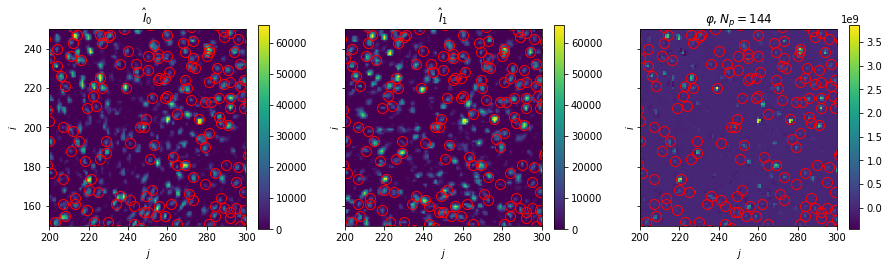

In [9]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 3.75))

for i, ax in enumerate(axes[:2]):
    im = ax.imshow(warped_image_pair[i])
    fig.colorbar(im, ax=ax)
    ax.set(title=f"$\hat{{I}}_{i}$")

ax = axes[2]
im = ax.imshow(
    warped_image_pair_filt[0] * warped_image_pair_filt[1], interpolation="none"
)
fig.colorbar(im, ax=ax)
ax.set(title=rf"$\varphi, N_p={np.count_nonzero(c[box[2]:box[3],box[0]:box[1]])}$")

for ax in axes:
    ax.plot(
        peak_coords[1],
        peak_coords[0],
        "o",
        markerfacecolor="none",
        markersize=10,
        c="r",
    )
    ax.set(xlim=box[:2], ylim=box[2:], xlabel="$j$", ylabel="$i$")

## Plot: Disparity histogram

In [10]:
D_hist = [D[i][(np.abs(D[0]) > 0) & (np.abs(D[1]) > 0)] for i in range(2)]

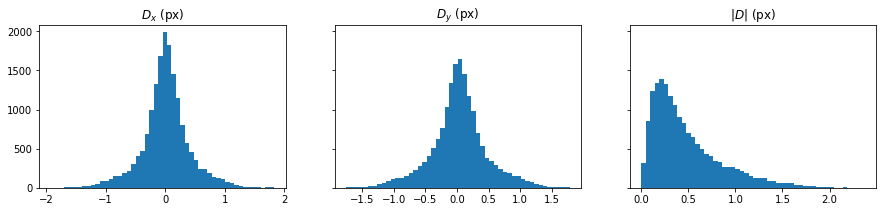

In [11]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(15, 3))

for ax, D_hist_i, label in zip(axes[:2], D_hist, ["$D_x$ (px)", "$D_y$ (px)"]):
    ax.hist(D_hist_i, bins=50)
    ax.set(title=label)

ax = axes[-1]
ax.hist(np.linalg.norm(D_hist, axis=0), bins=50)
ax.set(title="$|D|$ (px)");